# **Food Image Classification**

**Dataset:**

  The Dataset is obtained from Kaggle. This contains 11 classes of food images.


**Aim:** 

  The main objective of the project is to build a multi-class image classifier to identify the food category given an image of food.

**Neural Network Architecture used:**

This project experiements to build a model on Inception V3 architecture and VGG16 architecture using transfer learning and select the model that provides best accuracy.

Note : This colab notebook is for Inception V3 model and the another colab notebook is for VGG 16 model.

## **Load the Packages:**

In [ ]:
# import the basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# import tensorflow and related libraries
from tensorflow import keras
from keras.applications import inception_v3
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# import the metrics package for model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# importing package to display the image
import cv2
from google.colab.patches import cv2_imshow

# import packages to connect to google drive
from google.colab import drive

## **Accessing the Dataset**

In [ ]:
# the dataset is stored in google drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir("/content/drive/My Drive/Food-11 image dataset/")

In [ ]:
# there are 11 categories in Food-11 dataset
target_labels = ["Bread", 
                 "Dairy product", 
                 "Dessert", 
                 "Egg", 
                 "Fried food", 
                 "Meat", 
                 "Noodles-Pasta", 
                 "Rice", 
                 "Seafood", 
                 "Soup", 
                 "Vegetable-Fruit"]

In [ ]:
path = "/content/drive/My Drive/Food-11 image dataset/"

Inside the Folder "Food-11 image dataset", There are three folders :

>1) Train

>2) Validate

>3) Test

Each folders contain 11 sub-folder. Each sub-folder contains images of each food catgory.

In [ ]:
# creating a dictionary to obtain one/two image's file path from each food category.
img_dict = {}
for lbl in target_labels:
  img_dict[lbl] = (path+"training/"+lbl+"/0.jpg")
img_dict[lbl+"_2"] = (path+"training/"+lbl+"/1.jpg")

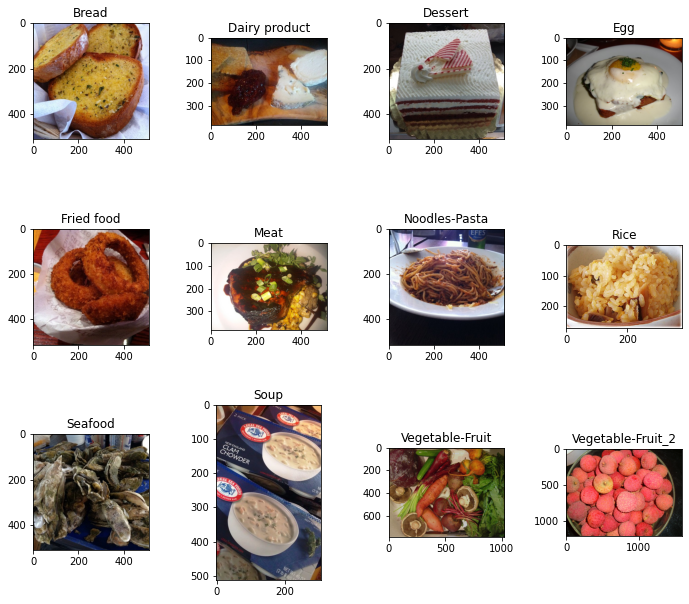

In [ ]:
# Some file paths obtained and stored in img_dict are being displayed
fig, ax = plt.subplots(nrows= 3, ncols= 4,figsize =  (10,9))

keys = list(img_dict.keys())

cnt = 0
for row in ax:
    for col in row:
        img = cv2.imread(img_dict[keys[cnt]])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img)
        col.imshow(img)
        col.set_title(keys[cnt])
        cnt += 1

fig. tight_layout(pad=2.0)
plt.show()

In [ ]:
# creating a function to plot the data distribution
def sub_set_graph(sub_folder):
    count_dict = {}
    summ = 0
    for food_type in os.listdir(path+sub_folder):
        count_dict[food_type] = len(os.listdir(path+sub_folder+"/"+food_type))
        summ += len(os.listdir(path+sub_folder+"/"+food_type))
        
    print("Number of Images in",sub_folder,"set are : ",summ)
    fig = plt.figure(figsize = (15,7))
    ax1 = fig.add_subplot(1,2,1)
    ax1 = sns.barplot(y = list(count_dict.keys()) , x= list(count_dict.values()))
    ax1.set_xlabel("Count of Images")
    ax1.set_ylabel("Food Type")
    txt = "Distribution of Food Types in"+sub_folder+"set"
    ax1.title.set_text(txt)
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.pie(list(count_dict.values()), labels = list(count_dict.keys()), autopct='%1.1f%%')
    ax2.set_title("Percentage of Images in Each Food Type")
    
    plt.show()

Number of Images in training set are :  9894


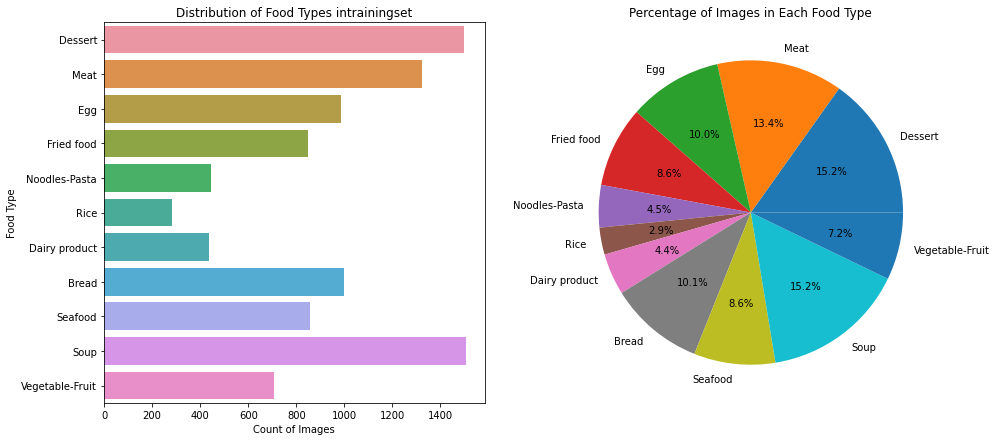

In [ ]:
# Training set distribution
sub_set_graph("training")

Number of Images in validation set are :  3435


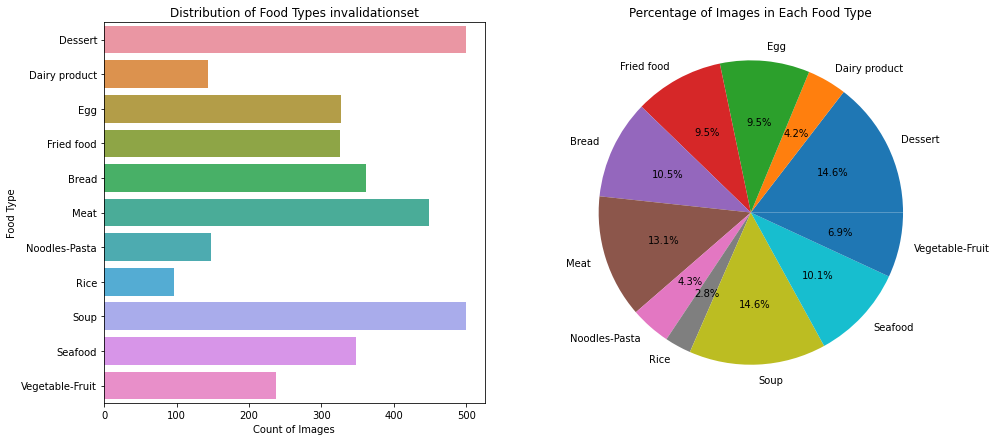

In [ ]:
# Validation set distribution
sub_set_graph("validation")

Number of Images in evaluation set are :  3360


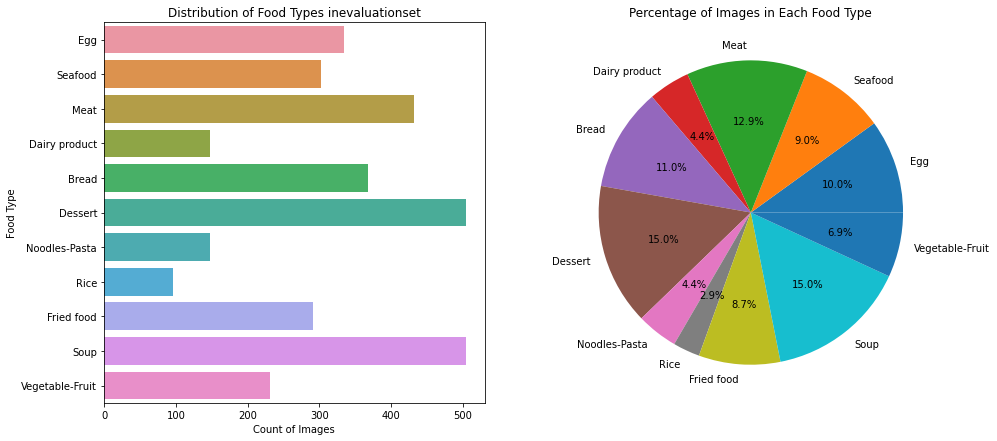

In [ ]:
# Test/Evaluation set distribution
sub_set_graph("evaluation")

From the above graphs we can see that train, test and validate set has almost same ratio of images in each category.

In [ ]:
print("Total Images are : ", 9866 + 3430 + 3347)

Total Images are :  16643


## **Data Augmentation**

For the images in train dataset alone the augmentation is used.

For train, validate and test dataset, the data is preprocessed into required format of Inception V3.

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=inception_v3.preprocess_input
        )

validate_datagen = ImageDataGenerator( preprocessing_function = inception_v3.preprocess_input
                                      )
test_datagen = ImageDataGenerator(preprocessing_function= inception_v3.preprocess_input)

In [ ]:
BATCH_SIZE = 64

In [ ]:
# flow from directory obtains images from the specified folders in the specified batch size.
# flow_from_directory provides to labels image, based on the name of the folder in which the image is present.
train_generator = train_datagen.flow_from_directory(path+"training",
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validate_generator = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(path+"evaluation",
                                             target_size=(299, 299),
                                             class_mode=None,
                                             classes= target_labels,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=42)

Found 9894 images belonging to 11 classes.
Found 3435 images belonging to 11 classes.
Found 3360 images belonging to 11 classes.


# **Inception V3 Model**

In [ ]:
# the Inception V3 is loaded as base model and neural network layers are added
base_model = inception_v3.InceptionV3(
    weights = "imagenet",
    include_top = False,
    input_shape = (299, 299, 3)
)
base_model.trainable = False

head_model = base_model.output 
head_model = Flatten()(head_model)
head_model = BatchNormalization()(head_model)
head_model = Dense(516, activation = 'relu')(head_model)
head_model = Dropout(0.3) (head_model)
head_model = BatchNormalization()(head_model)

head_model = Dense(156, activation = 'relu')(head_model)
head_model = Dropout(0.3) (head_model)
head_model = BatchNormalization()(head_model)

head_model = Dense(11, activation = 'softmax', name = "output")(head_model)
head_model = (head_model)

In [ ]:
model = Model(inputs = base_model.input, outputs = head_model)

# the loss, optimzer and metric for evaluation are set
model.compile(loss = "categorical_crossentropy",
             optimizer = "adam",
             metrics = "accuracy")

In [ ]:
filepath="/content/drive/My Drive/Food-11 image dataset/INCEPTION-V3-MODEL{epoch:02d}-{val_accuracy:.2f}.hdf5"


# the ModelCheckpoint mentioned here will save the model after an epoch if the "val-accuracy" has increased. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# if the accuracy of validation set is not increasing by atleast by 1% in 5 epochs the training will be stopped.
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 5,
    restore_best_weights = True,
)

This notebook is being trained in google colab, if more than 20 epochs are being run in colab then there are chances that allocated GPU is utilized and can get terminated.

So the model will the trained for 20 epochs, if the model is still improving then we can add another 20 epochs and continue training.

In [ ]:
incp_history = model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 20,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint, earlystopping],
    verbose=1
)

Epoch 1/20
154/154 [==============================] - 5041s 33s/step - loss: 1.0161 - accuracy: 0.6770 - val_loss: 0.5839 - val_accuracy: 0.8131

Epoch 00001: val_accuracy improved from -inf to 0.81309, saving model to /content/drive/My Drive/Food-11 image dataset/INCEPTION-V3-MODEL01-0.81.hdf5
Epoch 2/20
154/154 [==============================] - 254s 2s/step - loss: 0.6665 - accuracy: 0.7786 - val_loss: 0.5030 - val_accuracy: 0.8411

Epoch 00002: val_accuracy improved from 0.81309 to 0.84110, saving model to /content/drive/My Drive/Food-11 image dataset/INCEPTION-V3-MODEL02-0.84.hdf5
Epoch 3/20
154/154 [==============================] - 253s 2s/step - loss: 0.5672 - accuracy: 0.8142 - val_loss: 0.4707 - val_accuracy: 0.8552

Epoch 00003: val_accuracy improved from 0.84110 to 0.85525, saving model to /content/drive/My Drive/Food-11 image dataset/INCEPTION-V3-MODEL03-0.86.hdf5
Epoch 4/20
154/154 [==============================] - 253s 2s/step - loss: 0.5260 - accuracy: 0.8259 - val_los

We can see that for the past 5 epochs the accuracy did not increase more than 1%, it has increased from 86.822 to 87.441 (ie) 0.617% .So the model stopped training.

In [ ]:
# converting the epochs history to data frame and saving in drive
incp_history_frame = pd.DataFrame(incp_history.history)

In [ ]:
incp_history_frame.to_csv("inception_history.csv")
!cp inception_history.csv path

In [ ]:
# retrieving the saved file
incp_history_frame = pd.read_csv("inception_history.csv")
incp_history_frame.index  = np.arange(1,12) 
incp_history_frame.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
1,0,1.016095,0.677009,0.583948,0.813090
2,1,0.666479,0.778637,0.502959,0.841097


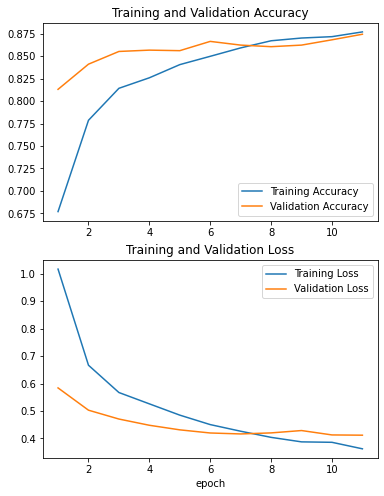

In [ ]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(incp_history_frame['accuracy'], label='Training Accuracy')
plt.plot(incp_history_frame['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(incp_history_frame['loss'], label='Training Loss')
plt.plot(incp_history_frame['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From the above graph we can se that the gap between val loss and loss starts increasing from epoch 8.

## **Evaluation of Inception Model**

In [ ]:
inception_model = load_model("INCEPTION-V3-MODEL11-0.87.hdf5")

In generator the "shuffle" parameter when evaluating a model, has to be set "False", so that the predictions from model and true_labels obtained are for the same image.


If the "shuffle" = True, the order of images predicted from data sub set (train/test) changes.

In [ ]:
 train_generator_shuffle = train_datagen.flow_from_directory(path+"training",
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=False,
                                               seed=42)

validate_generator_shuffle = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=False,
                                               seed=42)

Found 9894 images belonging to 11 classes.
Found 3435 images belonging to 11 classes.


In [ ]:
# a function to evaluate the prediction of dataset from a given model
def model_evaluation(model, generator):
  generator.reset() # There is a reset() method for the datagenerators which resets it to the first batch. So whenever you would want to correlate the model output with the filenames you need to set shuffle as False and reset the datagenerator before performing any prediction. This will ensure that our files are being read properly and there is nothing wrong with them.

  true_classes = generator.classes
  class_indices = dict((v,k) for k,v in generator.class_indices.items())
  preds = model.predict(generator)
  preds_classes = np.argmax(preds, axis=1)
  return [true_classes, preds_classes, generator.class_indices.keys()]

In [ ]:
# for the prediction made, this function prints a confusion matrix 
def plot_confusion_matrix(true_classes, preds_classes, target_names):
  cm = confusion_matrix(true_classes, preds_classes)

  df_cm = pd.DataFrame(cm, columns=target_names, index = target_names)
  plt.figure(figsize=(8,7))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap="YlGnBu") # font size , annot_kws={"size": 16}
  plt.title('Confusion Matrix\n', y=1.1)
  plt.ylabel('Actual label\n')
  plt.xlabel('Predicted label\n')

  plt.show()

In [ ]:
result_1 = model_evaluation(inception_model, train_generator_shuffle)
true_classes_1, preds_classes_1, target_names_1 = result_1[0], result_1[1], result_1[2]

train_acc = accuracy_score(true_classes_1, preds_classes_1) 
print("Inception Model without Fine-Tuning on Training  set has Accuracy: {:.2f}%".format(train_acc * 100))

Inception Model without Fine-Tuning on Training  set has Accuracy: 91.33%


In [ ]:
result_2 = model_evaluation(inception_model, validate_generator_shuffle)
true_classes_2, preds_classes_2, target_names_2 = result_2[0], result_2[1], result_2[2]

validate_acc = accuracy_score(true_classes_2, preds_classes_2) 
print("Inception Model without Fine-Tuning on Validation set has Accuracy: {:.2f}%".format(validate_acc * 100))

Inception Model without Fine-Tuning on Validation set has Accuracy: 87.42%


In [ ]:
print("Classification report of Validation set without Fine-Tuning : ")
print(classification_report(true_classes_2, preds_classes_2, target_names_2))

Classification report of Validation set without Fine-Tuning : 
                 precision    recall  f1-score   support

          Bread       0.87      0.82      0.85       362
  Dairy product       0.78      0.72      0.75       144
        Dessert       0.84      0.86      0.85       500
            Egg       0.78      0.87      0.82       327
     Fried food       0.84      0.86      0.85       326
           Meat       0.90      0.87      0.88       449
  Noodles-Pasta       0.97      0.98      0.97       147
           Rice       0.93      0.94      0.93        96
        Seafood       0.89      0.82      0.85       347
           Soup       0.95      0.95      0.95       500
Vegetable-Fruit       0.91      0.94      0.92       237

       accuracy                           0.87      3435
      macro avg       0.88      0.88      0.88      3435
   weighted avg       0.88      0.87      0.87      3435



Confusion Matrix of Validation set without Fine-Tuning : 


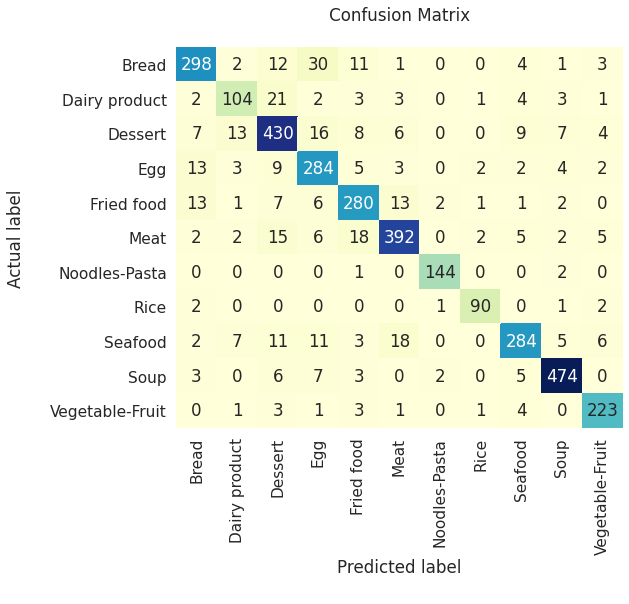

In [ ]:
print("Confusion Matrix of Validation set without Fine-Tuning : ")
plot_confusion_matrix(true_classes_2, preds_classes_2, target_name = target_names_2)

# **Fine Tuning:**

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in inception_model.layers[:249]:
   layer.trainable = False
for layer in inception_model.layers[249:]:
   layer.trainable = True

In [ ]:
# reducing the learning rate of  adam optimizer for fine tuning
opt = keras.optimizers.Adam(1e-5)

inception_model.compile(loss = "categorical_crossentropy",
             optimizer = opt,
             metrics = "accuracy")

# renaming the file path
filepath_ft="/content/drive/My Drive/Food-11 image dataset/INCEPTION-FT-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_ft = ModelCheckpoint(filepath_ft, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_ft = [checkpoint_ft]

In [ ]:
# the epoch from which the training must continue
initial_epoch = 11

In [ ]:
# fine tune the already trained model - inception.model
incp_ft_history = inception_model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    initial_epoch = initial_epoch,
    epochs = 32,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint_ft, earlystopping],
    verbose=1
)

Epoch 12/32
154/154 [==============================] - 262s 2s/step - loss: 0.4733 - accuracy: 0.8402 - val_loss: 0.4317 - val_accuracy: 0.8659

Epoch 00012: val_accuracy improved from -inf to 0.86586, saving model to /content/drive/My Drive/Food-11 image dataset/INCEPTION-FT-12-0.87.hdf5
Epoch 13/32
154/154 [==============================] - 256s 2s/step - loss: 0.3785 - accuracy: 0.8722 - val_loss: 0.4109 - val_accuracy: 0.8718

Epoch 00013: val_accuracy improved from 0.86586 to 0.87176, saving model to /content/drive/My Drive/Food-11 image dataset/INCEPTION-FT-13-0.87.hdf5
Epoch 14/32
154/154 [==============================] - 258s 2s/step - loss: 0.3523 - accuracy: 0.8831 - val_loss: 0.3945 - val_accuracy: 0.8756

Epoch 00014: val_accuracy improved from 0.87176 to 0.87559, saving model to /content/drive/My Drive/Food-11 image dataset/INCEPTION-FT-14-0.88.hdf5
Epoch 15/32
154/154 [==============================] - 260s 2s/step - loss: 0.3103 - accuracy: 0.8950 - val_loss: 0.3830 - v

In [ ]:
incp_ft_history_frame = pd.DataFrame(incp_ft_history.history)

In [ ]:
incp_ft_history_frame.to_csv("incp_ft_history_frame.csv")
!cp incp_ft_history_frame.csv path

In [ ]:
incp_ft_history_frame = pd.read_csv("incp_ft_history_frame.csv")
incp_ft_history_frame.index = np.arange(12,25)
incp_ft_history_frame.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
12,0,0.473318,0.840183,0.431727,0.865861
13,1,0.378477,0.872228,0.410898,0.871757


In [ ]:
inception_full_history = pd.concat([incp_history_frame, incp_ft_history_frame], axis=0)

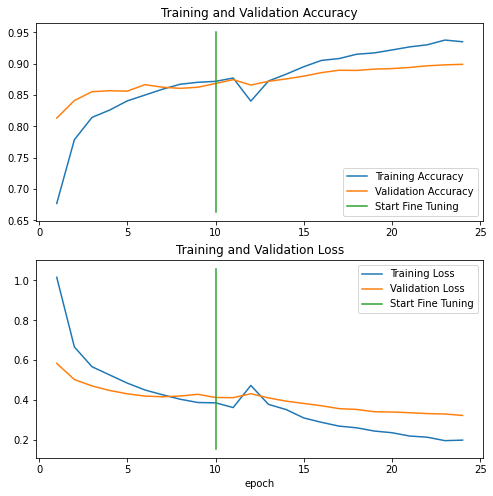

In [ ]:
acc = inception_full_history["accuracy"]
val_acc = inception_full_history['val_accuracy']

loss = inception_full_history['loss']
val_loss = inception_full_history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epoch-1,initial_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From the above graph we can see that the accuracy is increased after fine tuning till 20 epochs and starts overfitting, we see that the gaps starts increasing between val_accuracy and accuracy.

## **Evaluation of Fine-Tuned Inception Model**

In [ ]:
ft_inception_model = load_model("INCEPTION-FT-24-0.90.hdf5")

In [ ]:
result_3 =  model_evaluation(ft_inception_model, train_generator_shuffle)
true_classes_3, preds_classes_3, target_names_3 = result_3[0], result_3[1], result_3[2]

train_ft_acc = accuracy_score(true_classes_3, preds_classes_3) 
print("Inception Model WITH Fine-Tuning on Training set has Accuracy: {:.2f}%".format(train_ft_acc * 100))

Inception Model WITH Fine-Tuning on Training set has Accuracy: 96.69%


In [ ]:
result_4 =  model_evaluation(ft_inception_model, validate_generator_shuffle)
true_classes_4, preds_classes_4, target_names_4 = result_4[0], result_4[1], result_4[2]

validate_ft_acc = accuracy_score(true_classes_4, preds_classes_4) 
print("Inception Model WITH Fine-Tuning on Validation set has Accuracy: {:.2f}%".format(validate_ft_acc * 100))

Inception Model WITH Fine-Tuning on Validation set has Accuracy: 89.90%


In [ ]:
print(classification_report(true_classes_4, preds_classes_4,target_names =  target_names_4))

                 precision    recall  f1-score   support

          Bread       0.90      0.86      0.88       362
  Dairy product       0.85      0.78      0.81       144
        Dessert       0.85      0.88      0.86       500
            Egg       0.85      0.89      0.87       327
     Fried food       0.85      0.90      0.88       326
           Meat       0.91      0.90      0.90       449
  Noodles-Pasta       0.97      0.97      0.97       147
           Rice       0.96      0.96      0.96        96
        Seafood       0.89      0.88      0.88       347
           Soup       0.97      0.95      0.96       500
Vegetable-Fruit       0.95      0.93      0.94       237

       accuracy                           0.90      3435
      macro avg       0.90      0.90      0.90      3435
   weighted avg       0.90      0.90      0.90      3435



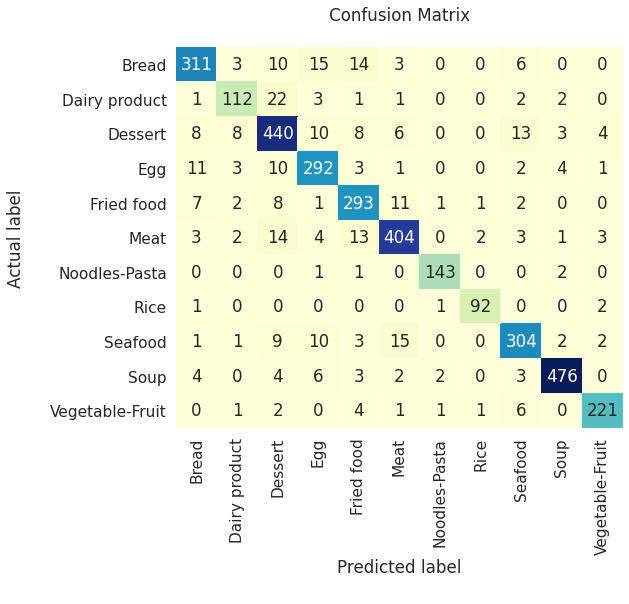

In [ ]:
plot_confusion_matrix(true_classes_4, preds_classes_4, target_names_4)

The fine-tuned Inception V3 model on validation set gives an accuracy of 89.90% and non fine-tuned model gives accuracy of 87.42%.

So the fine-tuned model is best among the Inception Models by 2.48%.

Let us fit the test set on the fine_tuned Inception V3 Model.

# **Accuracy of the Best Inception Model :**

In [ ]:
result_5 =  model_evaluation(ft_inception_model, test_generator)
true_classes_5, preds_classes_5, target_names_5 = result_5[0], result_5[1], result_5[2]

test_ft_acc = accuracy_score(true_classes_5, preds_classes_5) 
print("Inception Model WITH Fine-Tuning on Validation set has Accuracy: {:.2f}%".format(test_ft_acc * 100))

Inception Model WITH Fine-Tuning on Validation set has Accuracy: 91.88%
